In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
dt = 0.1  # Time step (seconds)
T_sim = 10.0 # Total simulation time
time = np.arange(0, T_sim, dt)
N_steps = len(time)

# --- 2. True System State (Constant Velocity Model) ---
# State vector x = [pos_x, vel_x, pos_y, vel_y]^T
true_x0 = np.array([0.0, 1.0, 5.0, -0.5]) # Initial state [x, vx, y, vy]

# State Transition Matrix F (Predicts next true state)
F = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

# --- 3. EKF Initialization ---
# EKF State estimate: x_hat = [pos_x, vel_x, pos_y, vel_y]^T
x_hat = np.zeros((4, N_steps))
x_hat[:, 0] = true_x0 + np.random.normal(0, 0.5, 4) # Initial guess with noise

# EKF Covariance Matrix P (Confidence in the state estimate)
P = np.eye(4) * 10.0 # High initial uncertainty

# Process Noise Covariance Q (Uncertainty in the dynamics model)
# We assume small, constant process noise
Q = np.diag([0.01, 0.01, 0.01, 0.01])

# Storage for true state and measurements
true_state = np.zeros((4, N_steps))
true_state[:, 0] = true_x0

In [ ]:
# --- 4. EKF Core Functions ---

def predict_state(x_k_minus_1, F):
    """Predicts the next state using the linear dynamics model."""
    return F @ x_k_minus_1

def predict_covariance(P_k_minus_1, F, Q):
    """Predicts the next covariance matrix."""
    return F @ P_k_minus_1 @ F.T + Q

# Non-linear Measurement Function for the Range Sensor
def h(x):
    """
    Measurement model: Converts the state vector [px, vx, py, vy]
    into the predicted measurements [camera1_x, camera1_y, camera2_x, camera2_y, range_dist].

    The range sensor measures the distance (hypotenuse) from the origin (0,0).
    h(x) = [px, py, px, py, sqrt(px^2 + py^2)]^T
    """
    px, _, py, _ = x # Extract position components
    distance = np.sqrt(px**2 + py**2)

    # We simulate 5 measurements:
    # 1. Camera 1 X, 2. Camera 1 Y, 3. Camera 2 X, 4. Camera 2 Y, 5. Range Distance
    return np.array([px, py, px, py, distance])

# Jacobian Matrix H (Linearization of the non-linear h function)
def H_jacobian(x):
    """
    Calculates the Jacobian matrix H of the measurement function h(x).
    H is a 5x4 matrix (5 measurements, 4 states).
    """
    px, _, py, _ = x

    # Derivative of distance w.r.t px: px / sqrt(px^2 + py^2)
    # Derivative of distance w.r.t py: py / sqrt(px^2 + py^2)

    # Handle division by zero near origin, though unlikely in a real scenario
    if px == 0.0 and py == 0.0:
        dist_partial_px = 0.0
        dist_partial_py = 0.0
    else:
        distance = np.sqrt(px**2 + py**2)
        dist_partial_px = px / distance
        dist_partial_py = py / distance

    # H = [dh1/dx, dh1/dvx, dh1/dy, dh1/dvy]
    #     [dh2/dx, dh2/dvx, dh2/dy, dh2/dvy]
    #     ...
    H = np.array([
        [1, 0, 0, 0],  # Camera 1 X (measures px)
        [0, 0, 1, 0],  # Camera 1 Y (measures py)
        [1, 0, 0, 0],  # Camera 2 X (measures px)
        [0, 0, 1, 0],  # Camera 2 Y (measures py)
        [dist_partial_px, 0, dist_partial_py, 0] # Range Distance (measures sqrt(px^2+py^2))
    ])
    return H

In [ ]:
# --- 5. Measurement Noise Covariance R ---
# R is a 5x5 matrix for our 5 measurements: [C1_x, C1_y, C2_x, C2_y, Range_dist]
# Diagonal entries represent the variance (standard deviation squared) for each sensor.
# R assumes no correlation between the sensor noises.

R = np.diag([
    0.5**2,  # Camera 1 X noise (std dev = 0.5 meters)
    0.5**2,  # Camera 1 Y noise (std dev = 0.5 meters)
    1.0**2,  # Camera 2 X noise (std dev = 1.0 meters - assumed noisier)
    1.0**2,  # Camera 2 Y noise (std dev = 1.0 meters - assumed noisier)
    1.5**2   # Range Sensor Distance noise (std dev = 1.5 meters - assumed poorest raw precision)
])

# Standard deviations (for direct use in noise generation)
R_std = np.sqrt(np.diag(R))

# Storage for the noisy measurements
Z_measured = np.zeros((5, N_steps))
C1_track = np.zeros((2, N_steps)) # Camera 1 (X, Y)
C2_track = np.zeros((2, N_steps)) # Camera 2 (X, Y)
R_track = np.zeros((1, N_steps)) # Range (Distance)

# --- 6. Generate True State and Noisy Measurements ---
for k in range(1, N_steps):
    # Propagate True State (Linear)
    true_state[:, k] = F @ true_state[:, k-1]

    # Generate True Measurement (Non-linear h)
    z_true = h(true_state[:, k])

    # Add noise to get the Simulated Measured State
    noise = np.random.normal(0, R_std)
    Z_measured[:, k] = z_true + noise

    # Store individual sensor tracks for plotting
    C1_track[:, k] = Z_measured[0:2, k] # (C1_x, C1_y)
    C2_track[:, k] = Z_measured[2:4, k] # (C2_x, C2_y)
    R_track[:, k] = Z_measured[4, k]    # Range Distance (Note: This is NOT a position track, but a measurement)

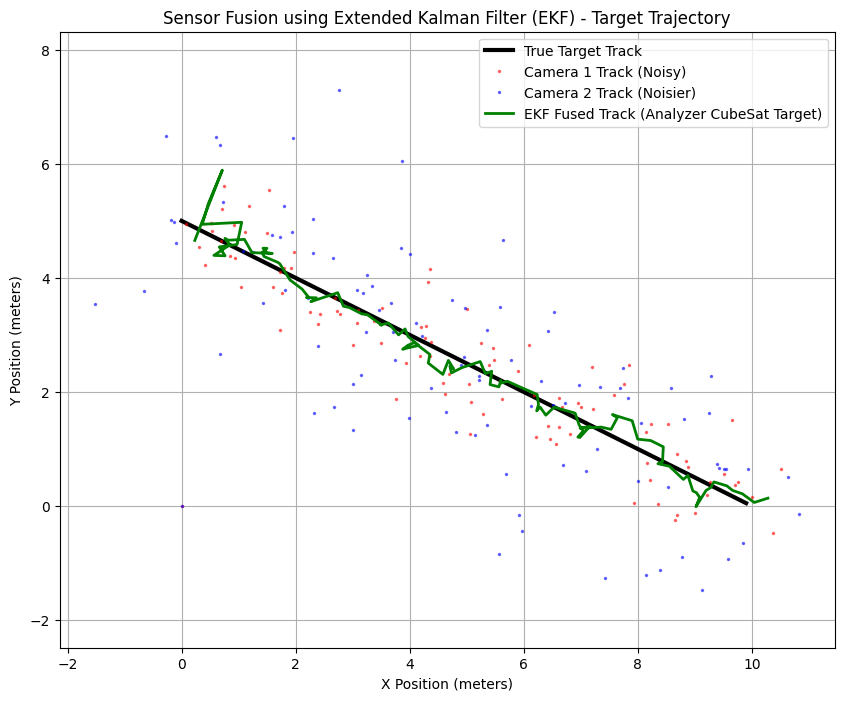

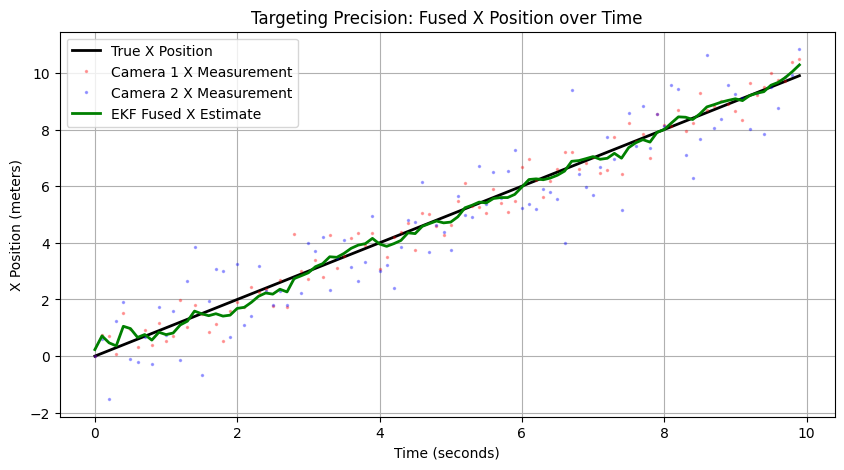


--- EKF Simulation Complete ---
Final EKF State Estimate (x, vx, y, vy): [10.28203015  1.24767902  0.13721547 -0.41178219]
Final True State (x, vx, y, vy): [ 9.9   1.    0.05 -0.5 ]


In [ ]:
# --- 7. EKF Main Loop (Fusion) ---

# We start from k=1 as k=0 is the initial condition
for k in range(1, N_steps):
    # --- A. Prediction Step ---
    # 1. Predict state: x_hat_k|k-1 = F * x_hat_k-1|k-1
    x_hat_prior = predict_state(x_hat[:, k-1], F)

    # 2. Predict covariance: P_k|k-1 = F * P_k-1|k-1 * F.T + Q
    P_prior = predict_covariance(P, F, Q)

    # --- B. Update Step (Fusion) ---
    # 3. Calculate Jacobian H and predicted measurement h(x_hat_prior)
    H_k = H_jacobian(x_hat_prior)
    z_hat_k = h(x_hat_prior) # Predicted measurement based on prior state estimate

    # 4. Calculate Innovation (Residual)
    # y_k = z_measured_k - h(x_hat_k|k-1)
    y_k = Z_measured[:, k] - z_hat_k

    # 5. Calculate Innovation Covariance S
    # S_k = H_k * P_k|k-1 * H_k.T + R
    S_k = H_k @ P_prior @ H_k.T + R

    # 6. Calculate Kalman Gain K
    # K_k = P_k|k-1 * H_k.T * inv(S_k)
    K_k = P_prior @ H_k.T @ np.linalg.inv(S_k)

    # 7. Update State Estimate
    # x_hat_k|k = x_hat_k|k-1 + K_k * y_k
    x_hat[:, k] = x_hat_prior + K_k @ y_k

    # 8. Update Covariance (using the faster 'Joseph form')
    # P_k|k = (I - K_k * H_k) * P_k|k-1
    P = (np.eye(4) - K_k @ H_k) @ P_prior # P is updated for the next iteration (k+1)

# --- 8. Visualization ---

# Extract final EKF track positions (x and y)
EKF_px = x_hat[0, :]
EKF_py = x_hat[2, :]

# Extract true track positions
True_px = true_state[0, :]
True_py = true_state[2, :]

# PLOT 1: X-Y Trajectory (The Target Track)
plt.figure(figsize=(10, 8))
plt.plot(True_px, True_py, 'k-', linewidth=3, label='True Target Track')
plt.plot(C1_track[0, :], C1_track[1, :], 'r.', alpha=0.5, markersize=3, label='Camera 1 Track (Noisy)')
plt.plot(C2_track[0, :], C2_track[1, :], 'b.', alpha=0.5, markersize=3, label='Camera 2 Track (Noisier)')
# NOTE: Range track is not position (x,y), so we don't plot it here.
plt.plot(EKF_px, EKF_py, 'g-', linewidth=2, label='EKF Fused Track (Analyzer CubeSat Target)')

plt.title('Sensor Fusion using Extended Kalman Filter (EKF) - Target Trajectory')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Important to keep proportions correct
plt.show()

# PLOT 2: Comparison of X Position Estimates vs. True Value
plt.figure(figsize=(10, 5))
plt.plot(time, True_px, 'k-', linewidth=2, label='True X Position')
plt.plot(time, C1_track[0, :], 'r.', alpha=0.3, markersize=3, label='Camera 1 X Measurement')
plt.plot(time, C2_track[0, :], 'b.', alpha=0.3, markersize=3, label='Camera 2 X Measurement')
plt.plot(time, EKF_px, 'g-', linewidth=2, label='EKF Fused X Estimate')

plt.title('Targeting Precision: Fused X Position over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('X Position (meters)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- EKF Simulation Complete ---")
print(f"Final EKF State Estimate (x, vx, y, vy): {x_hat[:, -1]}")
print(f"Final True State (x, vx, y, vy): {true_state[:, -1]}")